# FineTuning Bert For Classification

## Libraries

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# specify GPU
device = torch.device("cuda")

## Data-Visualisation, Pre-Processing & Feature Engineering

In [3]:
# Load dataset into a DataFrame
df = pd.read_csv("spamdata_v2.txt")
df.sample(5)

,label,text
2350,0,You will be in the place of that man
1373,1,"Bears Pic Nick, and Tom, Pete and ... Dick. In..."
5509,0,Lol they were mad at first but then they woke ...
1132,0,Good morning princess! How are you?
3470,0,Heart is empty without love.. Mind is empty wi...


In [4]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df['text'], df['label'], random_state=2024, test_size=0.3, stratify=df['label'])
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, random_state=2024, test_size=0.5, stratify=temp_labels)

* We will fine-tune the model using the train set and the validation set, and make predictions for the test set.

In [5]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


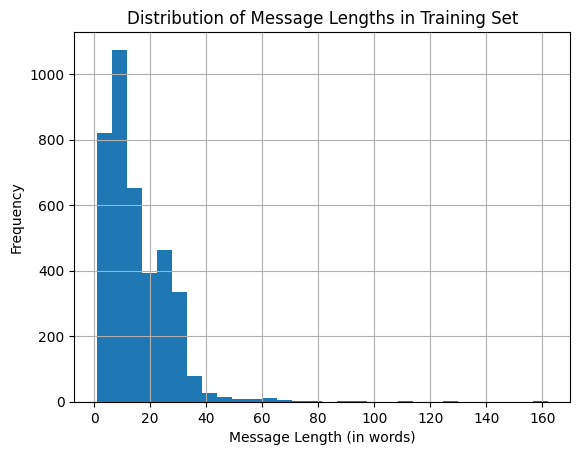

In [7]:
import matplotlib.pyplot as plt
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 30)
plt.xlabel('Message Length (in words)')
plt.ylabel('Frequency')
plt.title('Distribution of Message Lengths in Training Set')
plt.show()

In [8]:
# Convert to a Pandas Series to analyze
seq_len_series = pd.Series(seq_len)

# Minimum and maximum words in a sentence
min_words = seq_len_series.min()
max_words = seq_len_series.max()

# Frequency of each sentence length
freq_counts = seq_len_series.value_counts()

# Most common and least common sentence lengths
max_freq_length = freq_counts.idxmax()  # Sentence length with the highest frequency
max_freq = freq_counts.max()            # Maximum frequency of any sentence length

min_freq_length = freq_counts.idxmin()  # Sentence length with the lowest frequency
min_freq = freq_counts.min()            # Minimum frequency of any sentence length

# Print results
print(f"Minimum words in a sentence: {min_words}")
print(f"Maximum words in a sentence: {max_words}")
print(f"Most common sentence length (words): {max_freq_length} with frequency: {max_freq}")
print(f"Least common sentence length (words): {min_freq_length} with frequency: {min_freq}")

Minimum words in a sentence: 1
Maximum words in a sentence: 162
Most common sentence length (words): 6 with frequency: 308
Least common sentence length (words): 66 with frequency: 1


 **Choosing an Appropriate `max_length`**

- Setting `max_length` based on the typical length distribution of your dataset helps retain most relevant information.

In [9]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [10]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

* To send training data in batches and keep shuffling it every epoch

In [11]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [12]:
# freeze all the parameters
for param in bert.parameters():
  param.requires_grad = False

## Model-Architecture

Input → BERT → Dense(768→512) → ReLU → Dropout → Dense(512→2) → LogSoftmax → Output

In [32]:
class BERT_Arch(nn.Module):
  """
  BERT Architecture for text classification with 2 classes.
  The architecture includes:
  - BERT base model
  - Dropout for regularization
  - Two dense layers with ReLU activation
  - LogSoftmax output activation
  """
  def __init__(self, bert):
    # Initialize the parent class (nn.Module)
    super(BERT_Arch, self).__init__()

    # BERT layer
    self.bert = bert  # Pre-trained BERT model

    # Dropout layer (p=0.1) to prevent overfitting
    self.dropout = nn.Dropout(0.1)

    # ReLU activation function for non-linearity
    self.relu = nn.ReLU()

    # First dense layer: 768 (BERT output) -> 512 neurons
    self.fc1 = nn.Linear(768, 512)

    # Output layer: 512 -> 2 neurons (binary classification)
    self.fc2 = nn.Linear(512, 2)

    # LogSoftmax for output probabilities
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, sent_id, mask):
    # Get BERT output
    outputs = self.bert(sent_id, attention_mask=mask)

    # Get the [CLS] token representation
    # Most BERT models return the last hidden state as the first element
    cls_hs = outputs[0][:, 0, :]  # Get [CLS] token embedding
    '''
    cls_hs basically is the summary of entire sentence in a tensor format.
    It doesn't have any other purpose apart from interacting with other words and understand them as a whole!
    '''

    # Dense layer 1: BERT output -> 512
    x = self.fc1(cls_hs)

    # Apply ReLU activation
    x = self.relu(x)

    # Apply dropout
    x = self.dropout(x)

    # Dense layer 2: 512 -> 2 (output)
    x = self.fc2(x)

    # Apply softmax to get probabilities
    x = self.softmax(x)

    return x

In [33]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [44]:
# Display the model architecture
model

BERT_Arch(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_aff

In [34]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5) # learning rate

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


* Could use a schedular as well, but the data is very less so ignored.

In [35]:
# As there is a class imbalance we need to take care of that
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
print("Class Weights:", class_weights)

Class Weights: [0.57743559 3.72848948]


Why Use Class Weights?

apply **class weights** in the loss function. Class weights assign a higher "penalty" to misclassifications of the minority class. This helps the model pay more attention to underrepresented classes, improving its ability to correctly classify both classes.

In [36]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 10

## Model-Training

In [37]:
# function to train the model
def Train():

  model.train()

  total_loss, total_accuracy = 0, 0

  # empty list to save model predictions
  total_preds=[]

  # iterate over batches
  for step,batch in enumerate(train_dataloader):

    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch

    # clear previously calculated gradients
    model.zero_grad()

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [39]:
# function for evaluating the model
def evaluate():

  print("\nEvaluating...")

  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0

  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):

    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():

      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [40]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

for epoch in range(epochs):

  print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

  #train model
  train_loss, _ = Train()

  #evaluate model
  valid_loss, _ = evaluate()

  #save the best model
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'saved_weights.pt')

  # append training and validation loss
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  print(f'\nTraining Loss: {train_loss:.3f}')
  print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.648
Validation Loss: 0.593

 Epoch 2 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.563
Validation Loss: 0.503

 Epoch 3 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.478
Validation Loss: 0.415

 Epoch 4 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.404
Validation Loss: 0.346

 Epoch 5 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.341
Validation Loss: 0.296

 Epoch 6 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.293
Validation Loss: 0.260

 Epoch 7 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.263
Validation Loss: 0.236

 Epoch 8 / 10
  Batch    50  of    122.
  Batch   100  of    122.

Evaluating...

Training Loss: 0.237
Validat

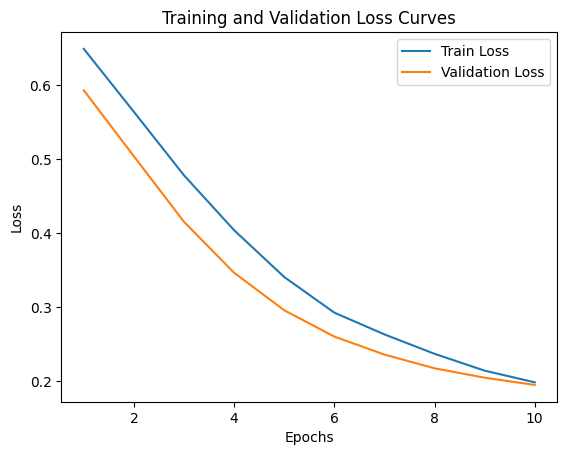

In [47]:
# Plot the loss curves
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(valid_losses)+1), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves')
plt.legend()
plt.show()

## Model-Evaluation

In [41]:
# Load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<ipython-input-41-5a29cc8ec3f6>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


<All keys matched successfully>

In [42]:
# Get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [43]:
# As we have applied soft-max label it with one having highest probability
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       724
           1       0.81      0.90      0.86       112

    accuracy                           0.96       836
   macro avg       0.90      0.94      0.92       836
weighted avg       0.96      0.96      0.96       836

